In [ ]:
!pip install MediaPipe

     |████████████████████████████████| 32.7 MB 220 kB/s 


In [1]:
!python /content/dataset/download_dataset.py
!python /content/dataset/stack_npy.py

Streaming output truncated to the last 5000 lines.
  inflating: 43_tur_id/images/PA/PA43_25.tif  
  inflating: 43_tur_id/images/PA/PA43_29.tif  
  inflating: 43_tur_id/images/PA/PA43_14.tif  
  inflating: 43_tur_id/images/PA/PA43_02.tif  
  inflating: 43_tur_id/images/PA/PA43_20.tif  
  inflating: 43_tur_id/images/PA/PA43_05.tif  
   creating: 43_tur_id/images/CS/
  inflating: 43_tur_id/images/CS/CS43_12.tif  
  inflating: 43_tur_id/images/CS/CS43_03.tif  
  inflating: 43_tur_id/images/CS/CS43_21.tif  
  inflating: 43_tur_id/images/CS/CS43_17.tif  
  inflating: 43_tur_id/images/CS/CS43_01.tif  
  inflating: 43_tur_id/images/CS/CS43_25.tif  
  inflating: 43_tur_id/images/CS/CS43_08.tif  
  inflating: 43_tur_id/images/CS/CS43_15.tif  
  inflating: 43_tur_id/images/CS/CS43_18.tif  
  inflating: 43_tur_id/images/CS/CS43_20.tif  
  inflating: 43_tur_id/images/CS/CS43_22.tif  
  inflating: 43_tur_id/images/CS/CS43_11.tif  
  inflating: 43_tur_id/images/CS/CS43_05.tif  
  inflating: 43_tur_id

In [2]:
import numpy as np
import scipy.sparse

def smoothSeq(seq):

    res = np.cumsum(seq, axis=1)
    seq_len = np.size(res, 1)
    res = res / np.expand_dims(np.linspace(1, seq_len, seq_len), 0)
    return res

def rootExpandKernelMap(X_train):

    element_sign=np.sign(X_train)
    nonlinear_value=np.sqrt(np.fabs(X_train))
    return np.vstack((nonlinear_value*(element_sign>0),nonlinear_value*(element_sign<0)))

def getNonLinearity(X_train,nonLin='ref'):

    if nonLin=='none':
        return X_train
    if nonLin=='ref':
        return rootExpandKernelMap(X_train)
    elif nonLin=='tanh':
        return np.tanh(X_train)
    elif nonLin=='ssr':
        return np.sign(X_train)*np.sqrt(np.fabs(X_train))
    else:
        raise("We don't provide {} non-linear transformation".format(nonLin))

def normalize(seq,norm='l2'):

    if norm=='l2':
        seq_norm = np.linalg.norm(seq, ord=2, axis=0)
        seq_norm[seq_norm == 0] = 1
        seq_norm = seq / np.expand_dims(seq_norm, 0)
        return seq_norm
    elif norm=='l1':
        seq_norm=np.linalg.norm(seq,ord=1,axis=0)
        seq_norm[seq_norm==0]=1
        seq_norm=seq/np.expand_dims(seq_norm,0)
        return seq_norm
    else:
        raise("We only provide l1 and l2 normalization methods")



def app_rank_pooling(time_seq,C = 1,NLStyle = 'ssr'):
    '''
    This function only calculate the positive direction of approximate rank pooling.
    :param time_seq: D x T
    :param C: hyperparameter
    :param NLStyle: Nonlinear transformation.Including: 'ref', 'tanh', 'ssr'.
    :return: Result of approximate rank pooling
    '''

    seq_smooth=smoothSeq(time_seq)
    seq_nonlinear=getNonLinearity(seq_smooth,NLStyle)
    seq_norm=normalize(seq_nonlinear)
    seq_len=np.size(seq_norm, 1)
    Labels=np.array(range(1,seq_len+1))
    seq_loss=scipy.sparse.csr_matrix(np.transpose(seq_norm))
    model.compile(optimizer=Adam(lr=1e-4), epsilon=0.1, tol=0.001, C=C,  loss='seq_loss', metrics=['accuracy', tf.keras.metrics.AUC()])
    #model.fit_generator(generator=t_generator(X_train, Y_train, 20),
    #                epochs=NO_OF_EPOCHS,
    #                    steps_per_epoch=(X_train.shape[0] // 20),
    #                    validation_data=v_generator(X_val, Y_val, 20),
     #                   validation_steps=(X_val.shape[0] // 20),
     #                   callbacks=[checkpoint, earlystopping, reduce_lr, tensorboard])
    

In [3]:
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from keras.callbacks import TensorBoard, ModelCheckpoint
from model.V_CNN import VCNN
import matplotlib.pyplot as plt 
import os
import random as rn
import tensorflow as tf
import time
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model

X = np.load('final_train.npy')
Y = np.load('final_mask.npy')

NO_OF_EPOCHS = 50
BATCH_SIZE = 128

IMAGE_SIZE = (256, 256)

SEED = 230
rn.seed(SEED)
np.random.seed(SEED)
#tf.set_random_seed(SEED)
tf.random.set_seed(SEED)


def t_generator(X_train, Y_train, batch_size):
  features = np.zeros(shape=(batch_size, 256,256,3))
  labels = np.zeros(shape=(batch_size, 256,256,1))
  while True:
    start = 0
    end = batch_size
    for i in range(243):
      features = X_train[start:end]
      labels = Y_train[start:end]
      start = end
      end = end + batch_size
      yield features / 255.0, labels / 255.0
      
def v_generator(X_val, Y_val, batch_size):
  features = np.zeros(shape=(batch_size, 256,256,3))
  labels = np.zeros(shape=(batch_size, 256,256,1))
  while True:
    start = 0
    end = batch_size
    for i in range(27):
      features = X_val[start:end]
      labels = Y_val[start:end]
      start = end
      end = end + batch_size
      yield features / 255.0, labels / 255.0

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, 
                                                    shuffle=True, 
                                                    random_state=265, 
                                                    test_size=0.1)
del X, Y
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, 
                                                  shuffle=True, 
                                                  random_state=265,
                                                  test_size=0.1)

model = VCNN()
#model.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy', metrics=['accuracy', metrics.mean_iou])
model.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC()])
    # configure callbacks
checkpoint = ModelCheckpoint("V_CNN.h5", verbose=1, save_best_only=True, save_weights_only=False,
                                 monitor='val_loss', mode='min')
earlystopping = EarlyStopping(patience=10, verbose=1, monitor='val_accuracy', mode='max')
reduce_lr = ReduceLROnPlateau(factor=0.2, patience=3, verbose=1, min_delta=0.000001,
                                  monitor='val_accuracy', mode='max')
tensorboard = TensorBoard(log_dir='./logs/' + time.strftime("%Y%m%d_%H%M%S"), histogram_freq=0,
                              write_graph=True, write_images=True)

 # train model
model.fit_generator(generator=t_generator(X_train, Y_train, 20),
                    epochs=NO_OF_EPOCHS,
                        steps_per_epoch=(X_train.shape[0] // 20),
                        validation_data=v_generator(X_val, Y_val, 20),
                        validation_steps=(X_val.shape[0] // 20),
                        callbacks=[checkpoint, earlystopping, reduce_lr, tensorboard])




Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 3)  12         ['input_1[0][0]']                
 alization)                                                                                       
                                                                                                  
 dropout (Dropout)              (None, 256, 256, 3)  0           ['batch_normalization[0][0]']    
                                                                                              

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:86: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/50
607/607 [==============================] - ETA: 0s - loss: 0.2233 - accuracy: 0.8798 - auc: 0.9609
Epoch 1: val_loss improved from inf to 0.09812, saving model to V_CNN.h5
607/607 [==============================] - 175s 261ms/step - loss: 0.2233 - accuracy: 0.8798 - auc: 0.9609 - val_loss: 0.0981 - val_accuracy: 0.9633 - val_auc: 0.9932 - lr: 1.0000e-04
Epoch 2/50
607/607 [==============================] - ETA: 0s - loss: 0.0749 - accuracy: 0.9691 - auc: 0.9951
Epoch 2: val_loss improved from 0.09812 to 0.05710, saving model to V_CNN.h5
607/607 [==============================] - 159s 262ms/step - loss: 0.0749 - accuracy: 0.9691 - auc: 0.9951 - val_loss: 0.0571 - val_accuracy: 0.9775 - val_auc: 0.9978 - lr: 1.0000e-04
Epoch 3/50
607/607 [==============================] - ETA: 0s - loss: 0.0445 - accuracy: 0.9810 - auc: 0.9982
Epoch 3: val_loss improved from 0.05710 to 0.04031, saving model to V_CNN.h5
607/607 [==============================] - 163s 269ms/step - loss: 0.0445 -

In [6]:
import cv2
import numpy as np
from keras.models import load_model
from tensorflow.keras.optimizers import Adam
from model.iou_loss import IoU
import matplotlib.pyplot as plt

model = load_model('/content/V_CNN.h5', compile=False)
model.compile(optimizer=Adam(1e-4), loss=IoU, metrics=['binary_accuracy'])

image_name = '/content/images/test.jpg'

img = cv2.imread(image_name)
h,w = img.shape[:2]
img = cv2.resize(img, (256,256))
img = img / 255.0
predict = model.predict(img.reshape(1,256,256,3))

output = predict[0]
output = cv2.resize(output, (w,h))
plt.imsave('output.jpg', output, cmap='gray')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning: skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.


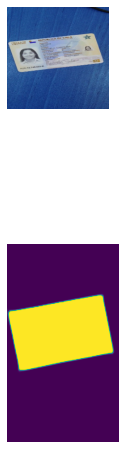

In [5]:
from skimage import data, segmentation, color
from skimage.future import graph
from matplotlib import pyplot as plt
import cv2

img = cv2.imread('/content/images/test.jpg')
img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.imread(image_name)
h,w = img.shape[:2]
img = cv2.resize(img, (256,256))
img = img / 255.0

labels1 = segmentation.slic(img, compactness=30, n_segments=20000)
out1 = color.label2rgb(labels1, img, kind='avg')
g = graph.rag_mean_color(img, labels1, mode='similarity')
labels2 = graph.cut_normalized(labels1, g)

out2 = color.label2rgb(labels2, img, kind='avg')
output = cv2.resize(output, (w,h))
predict=model.predict(img.reshape(1,256,256,3))
output = predict[0]
output = cv2.resize(output, (w,h))
fig, ax = plt.subplots(nrows=2, sharex=True, sharey=True, figsize=(6, 8))
ax[0].imshow(img)
# ax[1].imshow(out1)
ax[1].imshow(output)
for a in ax:
    a.axis('off')


fp="/content/images"
fn="op.jpg"
#plt.savefig(fp+fn) 
plt.show()